# How to combine lightcurves from different Kepler quarters

The Kepler mission took 17 quarters of continuous observations on the same targets. For applications such as finding long period planets or asteroseismology it is useful to be able to turn these quarters into one long light curve. We can do this using lightkurve's `append` function. The append function is called by doing

    stitched_lc = lc1.append(lc2)
    
It works in the same way as appending a list in python.

Below is an example of how to stitch together all the quarters for the exoplanet target Kepler-8b.

In [1]:
from lightkurve import search_lightcurvefile
target = 'Kepler-8b'

In [2]:
lc = search_lightcurvefile(target, quarter=1).download().PDCSAP_FLUX
for q in range(2,17):
    lc = lc.append(search_lightcurvefile(target, quarter=q).download().PDCSAP_FLUX)

Above we have created a `KeplerLightCurve` object from the first quarter of the data, choosing to use the PDCSAP_FLUX. Then we have looped through all the quarters, appending each new light curve to the fist one. We can plot this new `KeplerLightCurve` using the `plot` function (and all the other functions from previous tutorials will work too!)

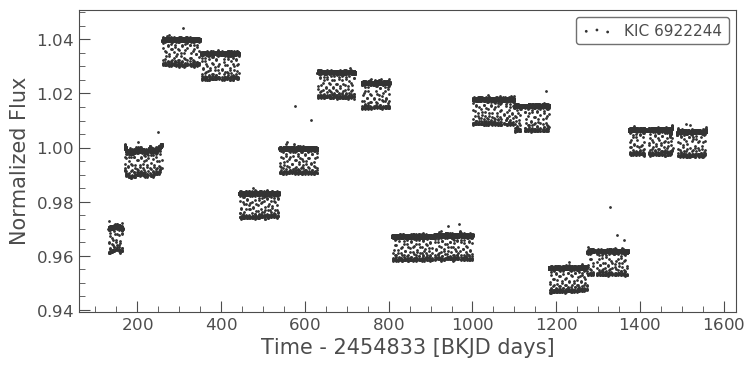

In [3]:
lc.scatter();

Unfortunately, as the light fell on difference pixels in each quarter and the spacecraft changed temperature during observation, these light curves all have difference offsets. We can remove them by normalizing each light curve before we append it. We can do this with the lightkurve function `normalize`.

In [4]:
lc = search_lightcurvefile(target, quarter=1).download().PDCSAP_FLUX.normalize()
for q in range(2,8):
    lc = lc.append(search_lightcurvefile(target, quarter=q).download().PDCSAP_FLUX.normalize())

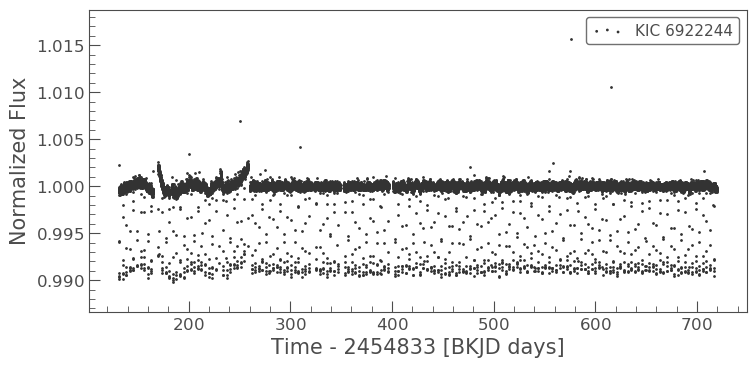

In [5]:
lc.scatter();

Now that the light curves are normalized they don't have significant offsets. However, there are clear long term trends in some of the early quarters of the data. We can remove this using lightkurve's `flatten` method before appending each object.

In [6]:
lc = search_lightcurvefile(target, quarter=1).download().PDCSAP_FLUX.normalize().flatten(window_length=401)
for q in range(2,8):
    lc = lc.append(search_lightcurvefile(target, quarter=q).download().PDCSAP_FLUX.normalize().flatten(window_length=401))

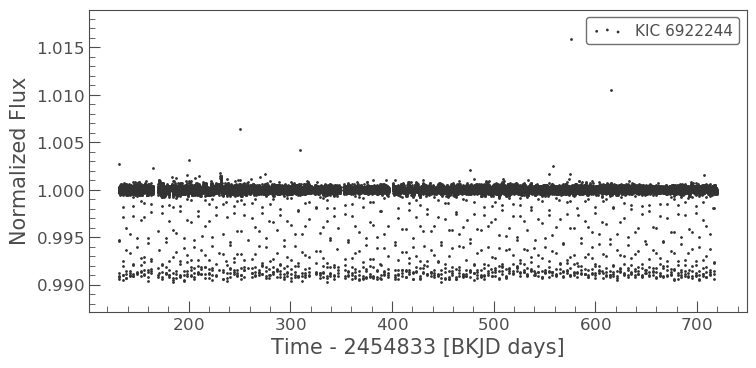

In [7]:
lc.scatter();

Now all of the light curves stitch together with no visible join. We can use the `fold` and `bin` methods to form a planet transit out of all of the data for Kepler-8b.

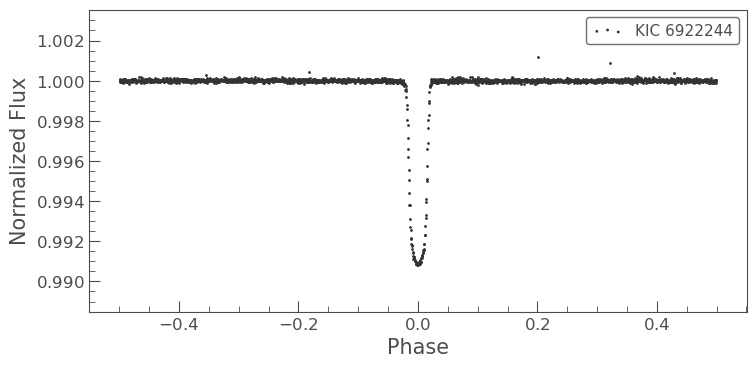

In [8]:
lc.fold(period=3.52254, t0=1.35).bin().scatter();